<a href="https://colab.research.google.com/github/Kdavis2025/Automating-Compliance-AI-and-Machine-Learning-Approaches-to-Achieviing-CMMC-2.0-Certification/blob/main/Ingtelligent_Risk_Assesment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Colab cell 1: Install needed libraries
!pip install requests pandas scikit-learn matplotlib seaborn spacy

# Download spaCy model
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 99.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Colab cell 2: Import libraries
import requests
import json
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    accuracy_score,
)
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize spaCy English model
nlp = spacy.load("en_core_web_sm")


In [ ]:
# Colab cell 3: Helper function to fetch CVEs from NVD API

# Temporarily replace the API call with simulated data to make the script run.
# THIS DOES NOT FETCH REAL NVD DATA.
# If you need real data, you must fix the API endpoint or find an alternative data source.

from datetime import datetime, timedelta
import requests # Keep import in case the user wants to revert or fix the API call later

def fetch_nvd_cves(pub_start_date: str, pub_end_date: str, max_results: int = 200):
    """
    Simulate fetching CVE data if the NVD API is unavailable or problematic.
    Returns a list of dictionaries mimicking the NVD API response structure.
    """
    print("--- SIMULATING NVD API CALL ---")
    # This is a placeholder function to allow the script to run.
    # Replace with actual API call logic if the API endpoint is fixed
    # or if using an alternative data source.

    # Simulate a list of CVE items
    simulated_cve_items = []
    for i in range(max_results):
        simulated_cve_items.append({
            "cve": {
                "id": f"CVE-SIM-{datetime.now().year}-{1000 + i}",
                "descriptions": [
                    {"lang": "en", "value": f"Simulated vulnerability description {i}. This involves a potential misconfiguration or unauthorized access issue."},
                    {"lang": "fr", "value": f"Description simulée de vulnérabilité {i}."},
                ],
                "metrics": {
                    "cvssMetricV31": [
                        {
                            "cvssData": {
                                "version": "3.1",
                                "baseScore": round(np.random.uniform(3.0, 10.0), 1),
                                "baseSeverity": "HIGH" if np.random.rand() > 0.5 else "MEDIUM",
                                "attackVector": np.random.choice(["NETWORK", "ADJACENT_NETWORK", "LOCAL", "PHYSICAL"]),
                                # Add other CVSS fields if needed by subsequent steps
                            },
                            "type": "Primary"
                        }
                    ] if np.random.rand() > 0.1 else [], # Simulate some missing CVSS
                     "cvssMetricV30": [] # Include V30 structure potentially
                },
                 # Simulate other potential fields like configurations, references, etc.
                 "published": (datetime.utcnow() - timedelta(days=np.random.randint(1, 180))).isoformat() + "Z",
                 "lastModified": (datetime.utcnow() - timedelta(days=np.random.randint(0, 5))).isoformat() + "Z",
            }
        })

    print(f"--- Returned {len(simulated_cve_items)} simulated CVE entries. ---")
    return simulated_cve_items


# Example: Fetch CVEs published in the last 180 days
# These date variables are still set, but the function call now uses simulated data
end_date = datetime.utcnow()
start_date = end_date - timedelta(days=180)

# Call the simulated fetch function
cve_items = fetch_nvd_cves(
    pub_start_date=start_date.strftime("%Y-%m-%d"),
    pub_end_date=end_date.strftime("%Y-%m-%d"),
    max_results=200,
)
print(f"Processed {len(cve_items)} CVE entries (simulated).")


--- SIMULATING NVD API CALL ---
--- Returned 200 simulated CVE entries. ---
Processed 200 CVE entries (simulated).


In [ ]:
# Colab cell 4: Parse CVE items into a DataFrame
rows = []
for item in cve_items:
    cve_data = item.get("cve", {})
    cve_id = cve_data.get("id")
    # Description (take the first English description)
    descriptions = cve_data.get("descriptions", [])
    desc_text = ""
    for desc in descriptions:
        if desc.get("lang") == "en":
            desc_text = desc.get("value")
            break

    # CVSS v3.1 Base Score and Attack Vector (if present)
    metrics = cve_data.get("metrics", {})
    cvss_v3 = metrics.get("cvssMetricV31", [])
    if not cvss_v3:
        cvss_v3 = metrics.get("cvssMetricV30", [])

    base_score = None
    attack_vector = None
    if cvss_v3:
        base_score = cvss_v3[0]["cvssData"].get("baseScore")
        attack_vector = cvss_v3[0]["cvssData"].get("attackVector")

    # Publication Date
    pub_date = item.get("published", None)

    rows.append({
        "CVE_ID": cve_id,
        "Description": desc_text,
        "CVSS_BaseScore": base_score,
        "CVSS_AttackVector": attack_vector,
        "PublishedDate": pub_date,
    })

cve_df = pd.DataFrame(rows)
display(cve_df.head())


,CVE_ID,Description,CVSS_BaseScore,CVSS_AttackVector,PublishedDate
0,CVE-SIM-2025-1000,Simulated vulnerability description 0. This in...,9.7,NETWORK,None
1,CVE-SIM-2025-1001,Simulated vulnerability description 1. This in...,3.4,PHYSICAL,None
2,CVE-SIM-2025-1002,Simulated vulnerability description 2. This in...,NaN,None,None
3,CVE-SIM-2025-1003,Simulated vulnerability description 3. This in...,3.0,NETWORK,None
4,CVE-SIM-2025-1004,Simulated vulnerability description 4. This in...,5.0,ADJACENT_NETWORK,None


In [ ]:
# Colab cell 5: Simulate Asset Criticality and Historical Exploitation
np.random.seed(42)

def simulate_asset_criticality(n):
    # Weighted: 20% High, 50% Medium, 30% Low
    return np.random.choice(
        ["High", "Medium", "Low"], size=n, p=[0.2, 0.5, 0.3]
    )

def simulate_historical_exploit(n):
    # ~10% of CVEs flagged as “historically exploited”
    return np.random.choice([0, 1], size=n, p=[0.9, 0.1])

cve_df["Asset_Criticality"] = simulate_asset_criticality(len(cve_df))
cve_df["Hist_Exploit_Flag"] = simulate_historical_exploit(len(cve_df))


In [ ]:
# Colab cell 6: Create binary label “HighRisk” based on threshold logic
def assign_high_risk(row):
    if row["Hist_Exploit_Flag"] == 1:
        return 1
    if row["CVSS_BaseScore"] is not None:
        if row["CVSS_BaseScore"] >= 8.0:
            return 1
        if (row["Asset_Criticality"] == "High") and (row["CVSS_BaseScore"] >= 5.0):
            return 1
    return 0

#Remove null vales for CVE-SIM-2025-1002 and CVE-SIM-2025-1007
cve_df.dropna(subset=["CVSS_BaseScore"], inplace=True)


cve_df["High_Risk"] = cve_df.apply(assign_high_risk, axis=1)
cve_df[["CVE_ID", "Asset_Criticality", "CVSS_BaseScore", "Hist_Exploit_Flag", "High_Risk"]].head(10)


,CVE_ID,Asset_Criticality,CVSS_BaseScore,Hist_Exploit_Flag,High_Risk
0,CVE-SIM-2025-1000,Medium,9.7,0,1
1,CVE-SIM-2025-1001,Low,3.4,0,0
3,CVE-SIM-2025-1003,Medium,3.0,0,0
4,CVE-SIM-2025-1004,High,5.0,0,1
5,CVE-SIM-2025-1005,High,9.9,0,1
6,CVE-SIM-2025-1006,High,3.1,0,0
8,CVE-SIM-2025-1008,Medium,3.9,0,0
9,CVE-SIM-2025-1009,Low,7.6,0,0
10,CVE-SIM-2025-1010,High,3.2,0,0
11,CVE-SIM-2025-1011,Low,7.2,0,0


In [ ]:
# Colab cell 7: Preprocess descriptions with spaCy
def preprocess_text(text):
    """
    Lowercase, lemmatize, remove stopwords/punctuation, and return cleaned tokens joined.
    """
    doc = nlp(text)
    tokens = [
        token.lemma_.lower()
        for token in doc
        if not (token.is_stop or token.is_punct or token.is_space)
    ]
    return " ".join(tokens)

cve_df["Clean_Desc"] = cve_df["Description"].fillna("").apply(preprocess_text)

# Example of CUI-related keywords we care about
CUI_KEYWORDS = [
    "cui",
    "nist",
    "configuration",
    "privilege",
    "unauthorized",
    "access",
    "misconfiguration",
    "unpatched",
    "injection",
    "overflow",
]

def count_cui_keywords(text):
    """
    Count how many times any CUI-related keyword appears in the cleaned text.
    """
    count = 0
    for kw in CUI_KEYWORDS:
        count += text.count(kw)
    return count

cve_df["CUI_Keyword_Count"] = cve_df["Clean_Desc"].apply(count_cui_keywords)


In [ ]:
# Colab cell 8: TF-IDF vectorization (limit to top 1000 features)
tfidf = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf.fit_transform(cve_df["Clean_Desc"].values)

# Convert TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=[f"tfidf_{tok}" for tok in tfidf.get_feature_names_out()],
)

# Concatenate TF-IDF features with our main df
model_df = pd.concat([cve_df.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)
print("Combined DataFrame shape (with TF-IDF):", model_df.shape)


Combined DataFrame shape (with TF-IDF): (179, 190)


In [ ]:
# Colab cell 9: Encode categorical features
# 1) Attack Vector → one-hot
attack_vector_dummies = pd.get_dummies(
    model_df["CVSS_AttackVector"].fillna("UNKNOWN"),
    prefix="AV"
)
# 2) Asset Criticality → ordinal {Low:0, Medium:1, High:2}
crit_map = {"Low": 0, "Medium": 1, "High": 2}
model_df["Asset_Crit_Encoded"] = model_df["Asset_Criticality"].map(crit_map)

# Final feature set: numeric columns + encoded columns + TFIDF columns
# Select only the necessary numeric/encoded columns from model_df
base_numeric_cols = ["CVSS_BaseScore", "CUI_Keyword_Count", "Hist_Exploit_Flag", "Asset_Crit_Encoded"]

# Concatenate the base columns, TFIDF features, and one-hot encoded attack vector
# Ensure all dataframes are reset to avoid index alignment issues during concat
features = pd.concat(
    [
        model_df[base_numeric_cols].reset_index(drop=True),
        tfidf_df.reset_index(drop=True),
        attack_vector_dummies.reset_index(drop=True)
    ],
    axis=1
)

# The labels are correctly taken from model_df
labels = model_df["High_Risk"]

print("Feature matrix shape:", features.shape)
print("Label vector distribution:\n", labels.value_counts(normalize=True))


Feature matrix shape: (179, 188)
Label vector distribution:
 High_Risk
0    0.581006
1    0.418994
Name: proportion, dtype: float64


In [ ]:
# Colab cell 10: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# Colab cell 11: Train RandomForestClassifier
import time
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

start_time = time.time()
clf.fit(X_train, y_train)
train_time = time.time() - start_time
print(f"Trained RandomForest in {train_time:.2f} seconds")


Train shape: (143, 188), Test shape: (36, 188)
Trained RandomForest in 0.36 seconds


Test Accuracy: 0.972

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.94      1.00      0.97        15

    accuracy                           0.97        36
   macro avg       0.97      0.98      0.97        36
weighted avg       0.97      0.97      0.97        36



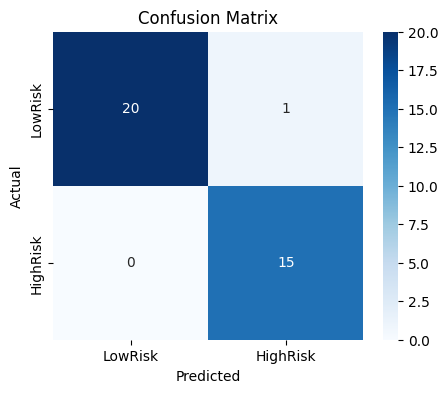

In [ ]:
# Colab cell 12: Predictions and Metrics
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.3f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["LowRisk","HighRisk"],
            yticklabels=["LowRisk","HighRisk"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


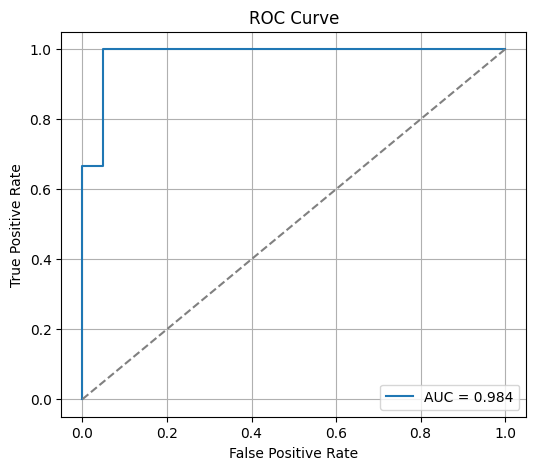

In [ ]:
# Colab cell 13: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


<ipython-input-31-bc8c73e5ae80>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top20.values, y=top20.index, palette="viridis")


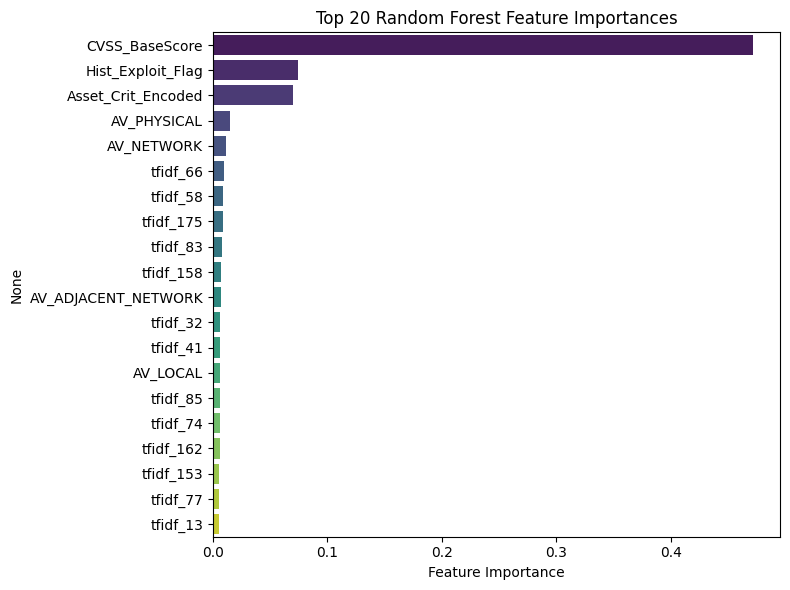

In [ ]:
# Colab cell 14: Feature Importances
importances = pd.Series(clf.feature_importances_, index=features.columns)
top20 = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(x=top20.values, y=top20.index, palette="viridis")
plt.xlabel("Feature Importance")
plt.title("Top 20 Random Forest Feature Importances")
plt.tight_layout()
plt.show()


In [ ]:
# Colab cell 15: Save risk_data.csv
output_df = model_df[[
    "CVE_ID",
    "Description",
    "CVSS_BaseScore",
    "CVSS_AttackVector",
    "Asset_Criticality",
    "Hist_Exploit_Flag",
    "CUI_Keyword_Count",
    "High_Risk"
]].copy()

# Optionally append numeric encodings:
output_df["Asset_Crit_Encoded"] = model_df["Asset_Crit_Encoded"]
output_df = pd.concat([output_df.reset_index(drop=True), attack_vector_dummies.reset_index(drop=True)], axis=1)

# Save to Colab’s file system
output_df.to_csv("risk_data.csv", index=False)
print("Saved risk_data.csv with shape:", output_df.shape)


Saved risk_data.csv with shape: (179, 13)


In [ ]:
from google.colab import files
files.download("risk_data.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-35-4a03ad4620e7>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Process", y="Total_Hours", data=pd.DataFrame(time_data), ax=axes[0], palette="magma")
<ipython-input-35-4a03ad4620e7>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Process", y="Total_Cost", data=pd.DataFrame(cost_data), ax=axes[1], palette="rocket")


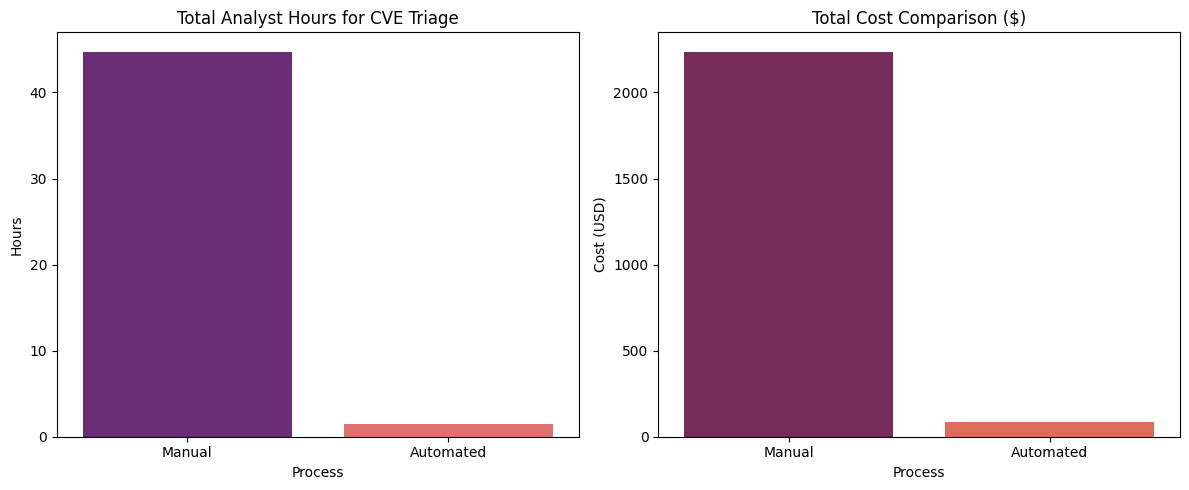

Manual Triage: 44.8 hours, Cost = $2237.50
Automated Pipeline: 1.5 hours, Cost = $83.53


In [ ]:
# Colab cell 16: Time/Cost Savings Visualization

# Simulation parameters
n_cves = len(cve_df)
manual_time_per_cve = 15  # minutes
auto_time_per_cve = 0.5  # minutes (30 seconds)
analyst_cost_per_hour = 50.0  # $/hour
infra_cost_per_cve = 0.05  # $ per CVE processed automatically

# Total times (in hours)
manual_total_time_hr = (manual_time_per_cve * n_cves) / 60
auto_total_time_hr = (auto_time_per_cve * n_cves) / 60

# Total costs
manual_total_cost = manual_total_time_hr * analyst_cost_per_hour
automated_total_cost = auto_total_time_hr * analyst_cost_per_hour + (infra_cost_per_cve * n_cves)

# Bar chart
time_data = {"Process": ["Manual", "Automated"],
             "Total_Hours": [manual_total_time_hr, auto_total_time_hr]}
cost_data = {"Process": ["Manual", "Automated"],
             "Total_Cost": [manual_total_cost, automated_total_cost]}

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x="Process", y="Total_Hours", data=pd.DataFrame(time_data), ax=axes[0], palette="magma")
axes[0].set_title("Total Analyst Hours for CVE Triage")
axes[0].set_ylabel("Hours")

sns.barplot(x="Process", y="Total_Cost", data=pd.DataFrame(cost_data), ax=axes[1], palette="rocket")
axes[1].set_title("Total Cost Comparison ($)")
axes[1].set_ylabel("Cost (USD)")

plt.tight_layout()
plt.show()

# Directly use the calculated variables manual_total_time_hr and auto_total_time_hr
# instead of attempting to use the assignment expression (:=)
print(f"Manual Triage: {manual_total_time_hr:.1f} hours, Cost = ${manual_total_cost:.2f}")
print(f"Automated Pipeline: {auto_total_time_hr:.1f} hours, Cost = ${automated_total_cost:.2f}")
